In [1]:
import brighteyes_ism.analysis.APR_lib as apr
import brighteyes_ism.analysis.FRC_lib as frc
import brighteyes_ism.analysis.Deconv_lib as dec
import brighteyes_ism.analysis.FocusISM_lib as fism
import brighteyes_ism.analysis.Graph_lib as gr
import brighteyes_ism.analysis.Tools_lib as tools
import brighteyes_ism.dataio.mcs as mcs
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle
from skimage.feature import peak_local_max
import scipy.fftpack
import numpy as np
import h5py
from scipy.optimize import curve_fit
import csv
import scipy.signal as signal
import itertools
import tifffile
from PIL import Image
from tqdm import tqdm

In [2]:
#pip install brighteyes_ism

## Set parameters

In [3]:
filename = "C:/Users/prism/Documents/carmaX/measurements/200nm lente 10cm" #no .h5
savename = "C:/Users/prism/Documents/carmaX/measurements/200nm lente 10cm"

rep = 30
spadFormat=7
index5=[8,9,10,11,12,15,16,17,18,19,22,23,24,25,26,29,30,31,32,33,36,37,38,39,40]
index3=[16,17,18,23,24,25,30,31,32]
index1=[17,23,24,25,31]

# Load data

In [4]:
f = h5py.File(filename + '.h5', 'r')
#for key in f.keys():
#    print(key)           #Names of the objects in HDF5 file - can be groups or datasets.
#    print(type(f[key]))  #check the object type
#print('\n')
group = f['Image']
#Check what keys are inside that group
#for key in group.keys():
#    print(key)

imgFormat=group.attrs['I_Height'][0]       #pixels
Depth=group.attrs['I_Depth'][0]            #repetitions/z
ImgFoV=group.attrs['I_XSpan[um]'][0]       #micron
pxsizex=group.attrs['I_XPixelSize[nm]'][0]/1000 #micron
ZSpan=group.attrs['I_ZSpan[um]'][0]        #micron
pxsizez=group.attrs['I_ZPixelSize[nm]'][0]/1000 #micron
Duration=group.attrs['M_Duration[ms]'][0]  #ms
DwellTime=Duration/(rep*Depth*imgFormat**2)    #ms

Fingerprint_h5 = group['Fingerprint'][()]
Data_h5= group['SPAD'][()]
f.close()

In [6]:
print('dwell time: ' + str(DwellTime))
print('FoV [um]: ' + str(ImgFoV))
print('Pixel size [um]: ' +str(pxsizex))

dwell time: 0.012207124965031941
FoV [um]: 20.0
Pixel size [um]: 0.0390625


In [7]:
Fingerprint_meta = np.reshape(Fingerprint_h5, (spadFormat,spadFormat))
Data_h5=np.reshape(Data_h5,(Depth,imgFormat,imgFormat,spadFormat**2)) 
print(Data_h5.shape) 

(1, 512, 512, 49)


In [9]:
#remove z if it's only one frame
Data=Data_h5.sum(axis=(0))
print(Data.shape)

(512, 512, 49)


In [10]:
d5 =[Data[:,:,i] for i in index5]
d5=np.transpose(np.asarray(d5),(1,2,0))
print(d5.shape)

d3 =[Data[:,:,i] for i in index3]
d3=np.transpose(np.asarray(d3),(1,2,0))
print(d3.shape)

d1 =[Data[:,:,i] for i in index1]
d1=np.transpose(np.asarray(d1),(1,2,0))
print(d1.shape)

(512, 512, 25)
(512, 512, 9)
(512, 512, 5)


#### Note: 
Data_h5 is organized as [rep,x,y,channel],     
Data is summed over repetitions and is the ISM dataset [x,y,channel]

## Check fingerprint and single images

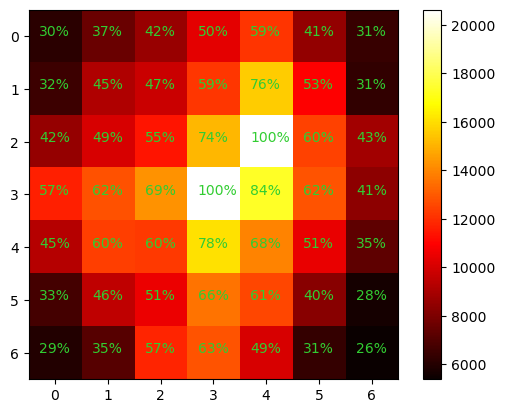

In [13]:
fingerprint = tools.fingerprint(Data)
fingerprint[1,5]=(fingerprint[1,4]+fingerprint[1,6])/2  #smooth spad 12
c= int((spadFormat-1)/2) 
fig= plt.figure()
plt.imshow(fingerprint, cmap='hot')
plt.colorbar()
for i in range(7):
    for j in range(7):
        plt.text(j-0.3,i, str(round(fingerprint[i,j]*100/fingerprint[c,c])) + '%', color='limegreen') 
        
fig.savefig(savename + ' fingeprint.png')

In [14]:
print(fingerprint)
np.savetxt(savename + ' fingerprint.txt', fingerprint, delimiter=' ')

[[ 6131  7549  8628 10378 12116  8523  6397]
 [ 6538  9187  9732 12214 15608 10950  6293]
 [ 8546 10038 11411 15141 20623 12418  8869]
 [11656 12804 14280 20580 17338 12825  8376]
 [ 9288 12400 12263 16080 13938 10484  7297]
 [ 6723  9516 10539 13549 12557  8261  5676]
 [ 5957  7113 11779 12881 10079  6358  5383]]


### Check images stack

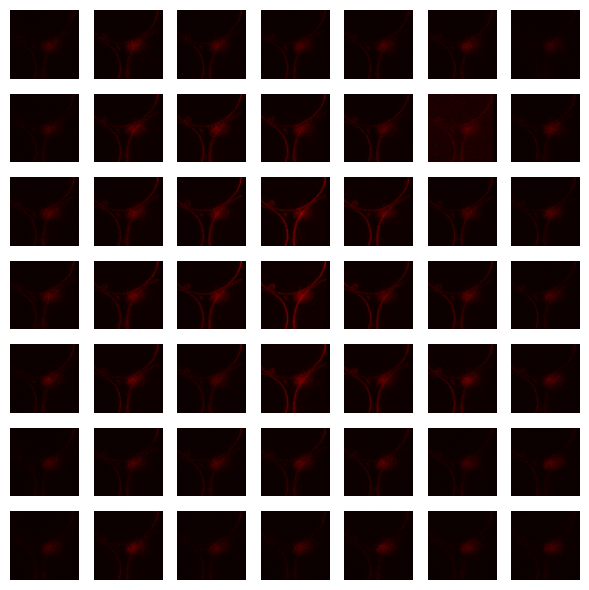

In [83]:
fig = gr.ShowDataset(Data,colorbar = False, normalize= False)

In [84]:
#Save all single images as a stack
tifffile.imwrite(savename + ' stack.tiff', np.transpose(Data, (2,0,1)))

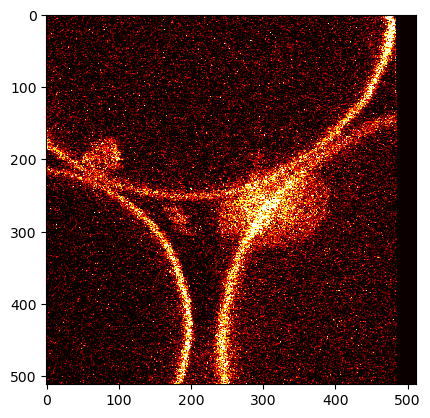

In [85]:
plt.imshow(Data[:,:,24], cmap='hot', vmax=3)

In [15]:
im = Image.fromarray(Data[:,:,24])
im.save(savename + ' central.tiff')

# Image reconstruction

Data is 7x7 with 12 (ref 24)

Data_cut is 7x7 without 12 (ref 23)

d5 is 5x5 with 12 (ref 12, 11 if wthout spad 12)

d3 is 3x3 (ref 4)

d1 are the first neighbors (ref 2)



## Confocal

In [15]:
Data_cut=np.delete(Data, 12,2)
print(Data_cut.shape)

(512, 512, 48)


(<Figure size 640x480 with 2 Axes>, <Axes: >)

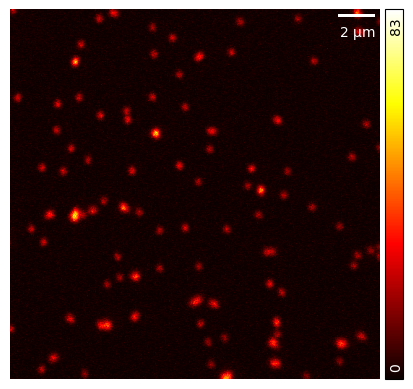

In [16]:
#confocal image
img_sum = Data_cut.sum(axis=-1)
gr.ShowImg(img_sum, pxsize_x = pxsizex)

In [17]:
im = Image.fromarray(img_sum)
im.save(savename + ' confocal.tiff')

## APR_ISM

In [18]:
#ISM image
usf = 10  #upsampling factor = subpixel precision
ref = 23 #reference image to compute the shift vectors
shift, img_ism = apr.APR(Data_cut, usf, ref, pxsize = pxsizex)
img_ism_sum = img_ism.sum(axis=-1) 

C:\Users\prism\anaconda3\Lib\brighteyes_ism\analysis\Graph_lib.py:544: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  ax.scatter(shift[:, 0], shift[:, 1], s=80, c=color, edgecolors='black', cmap=cmap)


Text(0.5, 1.0, 'Shift Vectors')

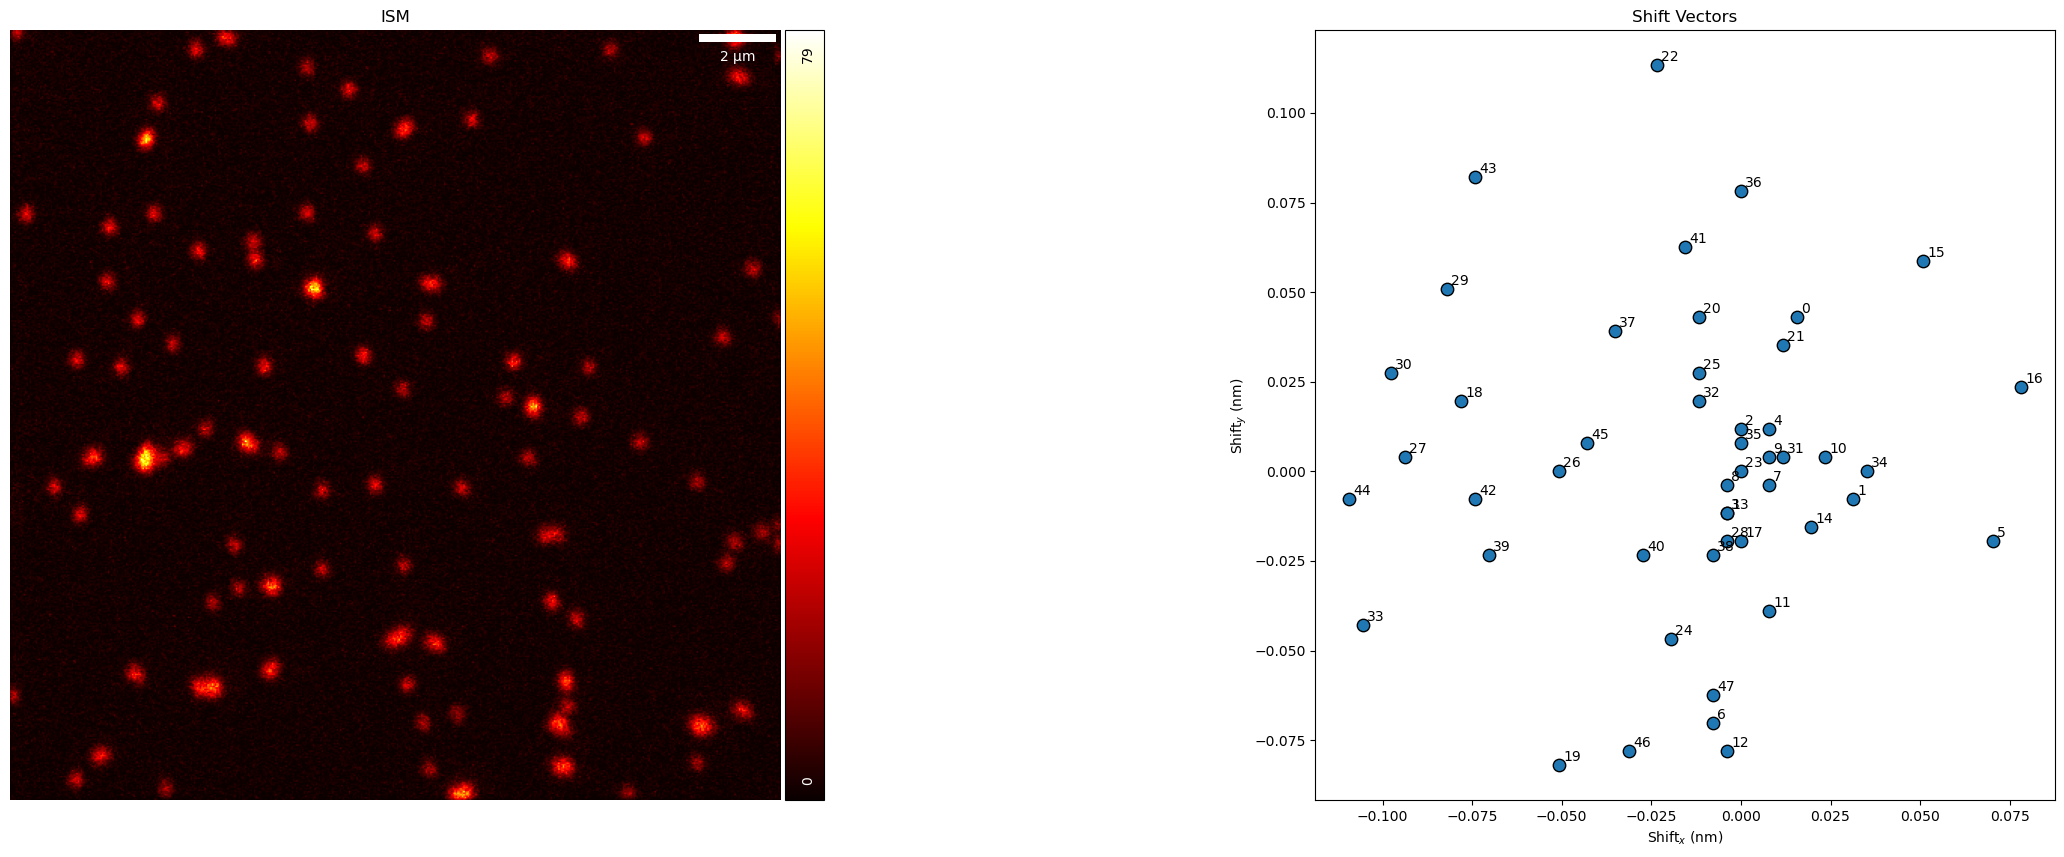

In [19]:
fig, ax = plt.subplots(1, 2, figsize=(30,10))

gr.ShowImg(img_ism_sum, pxsize_x = pxsizex, fig = fig, ax = ax[0])
ax[0].set_title('ISM')

gr.PlotShiftVectors(shift, fig = fig, ax = ax[1])
ax[1].set_title('Shift Vectors')
#ax[1].set_xlim(-0.15,0.15)
#ax[1].set_ylim(-0.15,0.15)

In [98]:
im = Image.fromarray(img_ism_sum)
im.save(savename + ' ISM d3.tiff')

extent = ax[1].get_window_extent().transformed(fig.dpi_scale_trans.inverted())
fig.savefig(savename + ' shift vectors d3.png', bbox_inches=extent.expanded(1.2, 1.2))

# Analisi risoluzione Erf

Compute the resolution for both Confocal and ISM dataset (and any reconstruction implemented in the future). Requires a txt file with the center positions of the particles and requires the number of particles and the ROi size as inputs.

## Initialization

In [607]:
#If using external Tiff, put here the file paths for confocal and ism

#img_sum=np.asarray(Image.open("G:/Drive condivisi/BioPhotonics/Riccardo/Ilaria tesi/2024 07 3 sfere 200nm/200nm 40mW dt0.01 campo1 confocal.tiff"))
img_ism_sum=np.asarray(Image.open("C:/Users/prism/Documents/carmaX/measurements/2024 07 11 200nm 60x/200nm 60x 60mW 2 ISS.tif"))
#plt.imshow(img_sum)
img_sum=Data[:,:,24]
pxsizex=0.039

In [ ]:
#Assign the SPAD 24 as confocal images when analyzing only the central spad

img_sum=Data[:,:,24]

## Find peaks

In [49]:
xc=peak_local_max(img_ism_sum,min_distance=20, threshold_abs=10)

maxvalues=np.zeros(xc.shape[0],dtype='float')
for i in range(xc.shape[0]):
    maxvalues[i]=img_ism_sum[xc[i,0],xc[i,1]]

    xc1=np.zeros((xc.shape[0],2))
n=0
for i in range(xc.shape[0]):
    if 110>maxvalues[i]>15: #Change value range
        xc1[n,:]=xc[i,:]
        n+=1       
xc1=xc1[0:n,:]

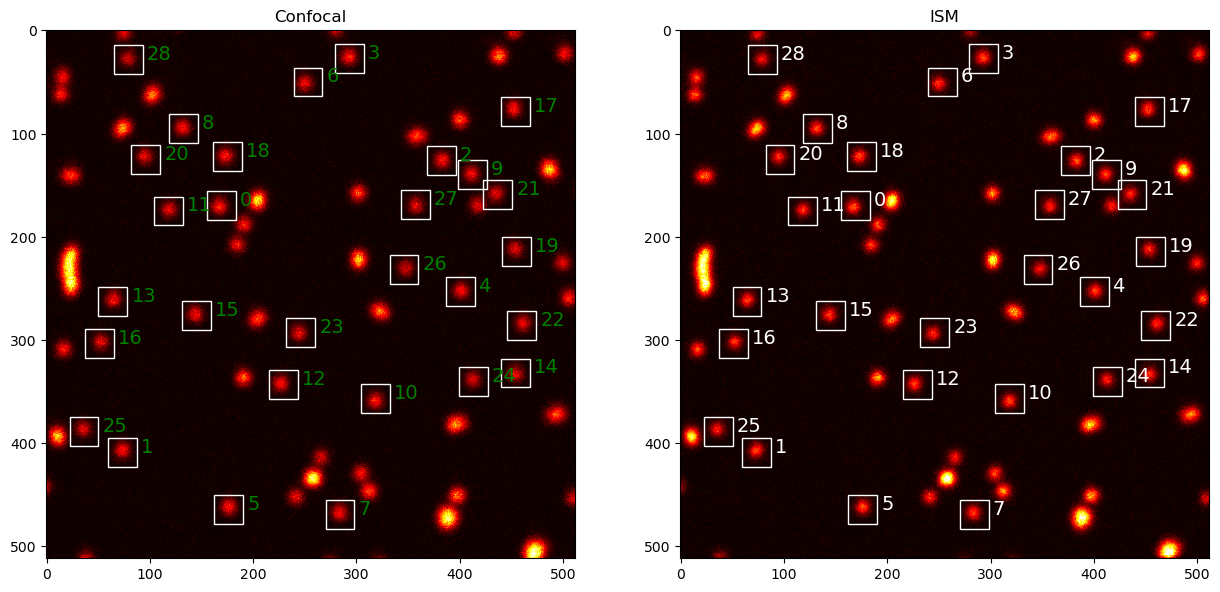

In [227]:
ROIsizeC = 28
Npart = xc1.shape[0]
fig, ax = plt.subplots(1, 2, figsize=(15,15))

ax[0].imshow(img_sum,cmap='hot', vmax=150)
#ax[0].scatter(xc1[:,1],xc1[:,0])
ax[0].set_title('Confocal')
for l in range(Npart):
    rect = Rectangle((xc1[l,1]-ROIsizeC/2,xc1[l,0]-ROIsizeC/2),ROIsizeC,ROIsizeC,linewidth=1,edgecolor='w',facecolor='none')
    ax[0].add_patch(rect)
    ax[0].text(xc1[l,1]+4+ROIsizeC/2, xc1[l,0], l, fontsize=14, color='green')
    
ax[1].imshow(img_ism_sum,cmap='hot', vmax=150)
ax[1].set_title('ISM')
for l in range(Npart):
    rect = Rectangle((xc1[l,1]-ROIsizeC/2,xc1[l,0]-ROIsizeC/2),ROIsizeC,ROIsizeC,linewidth=1,edgecolor='w',facecolor='none')
    ax[1].add_patch(rect)
    ax[1].text(xc1[l,1]+4+ROIsizeC/2, xc1[l,0], l, fontsize=14, color='white')   
ax = plt.gca()

In [51]:
#Remove specific particles
#Refresh the image above to see the updated indexes after every deletion!

xc1=np.delete(xc1,[5,2,0,1,4,3],0)
Npart = xc1.shape[0]

## Particles Fit

In [53]:
def erfC(x, amp, xc, w, offset):
    fitfunction=amp*w*w*np.pi*(1-scipy.special.erf((xc-x)/(np.sqrt(2.0)*w)))+offset*ROIsizeC*x
    return fitfunction

In [228]:
res_conf=np.zeros((Npart,3))
res_ism=np.zeros((Npart,3))
integrali_conf=np.zeros((Npart,ROIsizeC,2))
integrali_ism=np.zeros((Npart,ROIsizeC,2))

for l in range(0,Npart,1): #inizia il loop sulle particelle
    
    ROItemp_conf=np.zeros((ROIsizeC,ROIsizeC),dtype='float')
    ROItemp_ism=np.zeros((ROIsizeC,ROIsizeC),dtype='float')
    yi= (xc1[l,1]-ROIsizeC/2).astype(int)
    yf= (xc1[l,1]+ROIsizeC/2).astype(int)
    xi= (xc1[l,0]-ROIsizeC/2).astype(int)
    xf= (xc1[l,0]+ROIsizeC/2).astype(int)
    
    for i in range(xi,xf,1): #crea la ROI attorno alla NP
        for j in range(yi,yf,1):
            ROItemp_conf[i-xi][j-yi]=img_sum[i][j]
            ROItemp_ism[i-xi][j-yi]=img_ism_sum[i][j]
    #plt.imshow(ROItemp_conf.T)
    
    integral_conf=np.zeros(ROIsizeC+1,dtype='float')
    integral_ism=np.zeros(ROIsizeC+1,dtype='float')
    axisC=np.zeros(ROIsizeC+1,dtype='float')
    
    for i in range(ROIsizeC+1):
        axisC[i]=i
        
    for i in range(ROIsizeC):   
        for j in range(ROIsizeC):
            integral_conf[i]=integral_conf[i]+ROItemp_conf[j][i]
            integral_ism[i]=integral_ism[i]+ROItemp_ism[j][i]
        integral_conf[i+1]=integral_conf[i]
        integral_ism[i+1]=integral_ism[i]
            
    popt1, pcov1 = curve_fit(erfC, axisC, integral_conf, bounds=(0,np.inf), p0=(70,14,2,5))
    popt2, pcov2 = curve_fit(erfC, axisC, integral_ism, bounds=(0,np.inf), p0=(70,14,4,5))
    
    res_conf[l,0]=res_ism[l,0]=l
    res_conf[l,1]=popt1[2]*pxsizex*2.35
    res_ism[l,1]=popt2[2]*pxsizex*2.35
    res_conf[l,2]=popt1[0]
    res_ism[l,2]=popt2[0]
    
    
    for i in range(ROIsizeC):
        integrali_conf[l,i,0]=integral_conf[i]
        integrali_conf[l,i,1]=erfC(axisC,*popt1)[i]
        integrali_ism[l,i,0]=integral_ism[i]
        integrali_ism[l,i,1]=erfC(axisC,*popt2)[i]
    
print('Confocal Avg FWHM: \n' + str(np.mean(res_conf[:,1])) + ' +- ' + str(np.std(res_conf[:,1])) + '\n\n ISM Avg FWHM: \n' + str(np.mean(res_ism[:,1])) + ' +- ' + str(np.std(res_ism[:,1])))

Confocal Avg FWHM: 
0.4796058487603666 +- 0.02827392710914069

 ISM Avg FWHM: 
0.43263657009467965 +- 0.0319774527290058


In [229]:
print( 'Confocal results: \n' + str(res_conf) + '\n\n ISM results: \n' + str(res_ism))

Confocal results: 
[[ 0.          0.45917152 63.64381001]
 [ 1.          0.46369779 57.61082101]
 [ 2.          0.47296843 58.17738852]
 [ 3.          0.50462767 59.83295849]
 [ 4.          0.45081565 57.65883545]
 [ 5.          0.48874517 57.97263346]
 [ 6.          0.46803469 53.86608276]
 [ 7.          0.4810494  55.75123518]
 [ 8.          0.49717349 57.45574721]
 [ 9.          0.46491389 54.59396404]
 [10.          0.45427065 59.53904307]
 [11.          0.4994034  50.24620377]
 [12.          0.47376768 57.36073581]
 [13.          0.46900499 57.53165206]
 [14.          0.50904052 48.48216647]
 [15.          0.47714518 55.57493891]
 [16.          0.45884741 52.43688597]
 [17.          0.44982566 62.96947952]
 [18.          0.45884176 60.63842443]
 [19.          0.47773832 49.98710583]
 [20.          0.46217295 52.58382371]
 [21.          0.5735234  42.13854916]
 [22.          0.45977985 52.10363062]
 [23.          0.47314693 52.78519324]
 [24.          0.46660419 47.54796611]
 [25. 

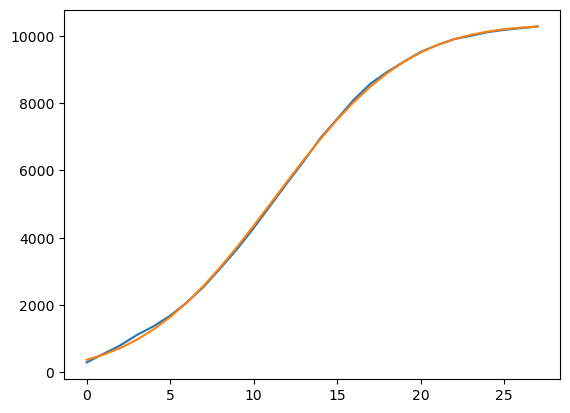

In [230]:
plt.plot(integrali_conf[21,:,0])
plt.plot(integrali_conf[21,:,1])

## Save the results

In [949]:
#Salva singoli integrali 
np.savetxt(savename + ' Erf particelle central.txt', np.transpose(integrali_conf[:,:,0]), delimiter=',')

In [ ]:
# Save All results as : Index, Confocal FWHM, Confocal Amplitude, ISM FWHM, ISM amplitude

f=open(savename + ' Fit results.txt', 'w')

for i in range(Npart):
    f.write(str(i)+','+str(res_conf[i,1])+','+str(res_conf[i,2])+','+str(res_ism[i,1])+','+str(res_ism[i,2])+'\n')
f.close()

In [950]:
#save only the data for the SPAD 24 (use confocal results if the image is assigned as img_sum)
f=open(savename + ' Fit results central.txt', 'w')

for i in range(Npart):
    f.write(str(i)+','+str(res_conf[i,1])+','+str(res_conf[i,2])+'\n')
f.close()